In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
import pandas as pd


In [2]:
# Load world data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world.head()

/var/folders/3l/1dkgnv_x37jb0wvp887c3y640000gn/T/ipykernel_52821/4239409945.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


<Axes: >

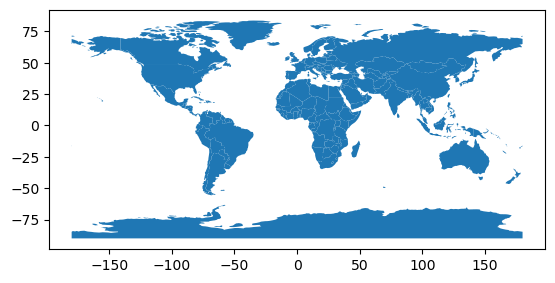

In [3]:
world.plot()

<Axes: >

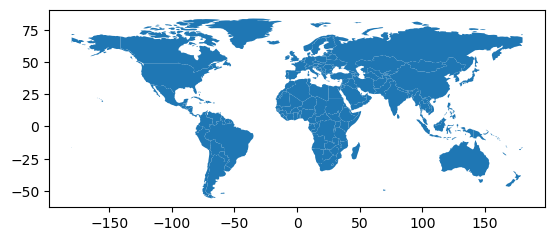

In [4]:
# Removing some continents - let's say you want to remove Antarctica
world1 = world[~world['continent'].isin(['Antarctica'])]

world1.plot()

In [5]:
world1.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

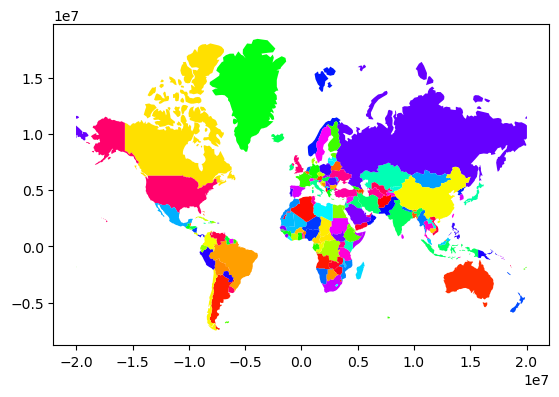

In [6]:
world_data_copy = world1.copy()
world_data_copy.to_crs(epsg=3857, inplace=True)
world_data_copy.plot(column='name', cmap='hsv')
plt.show()

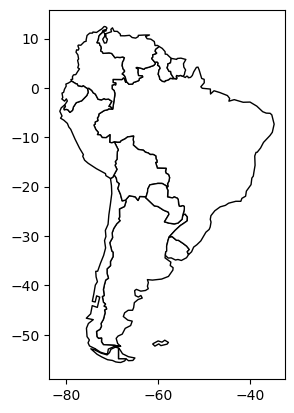

In [7]:
# We restrict to South America.
south_america = world[world.continent == 'South America'].plot(color='white', edgecolor='black')


### Lets try to plot Asia continent with all its countries.

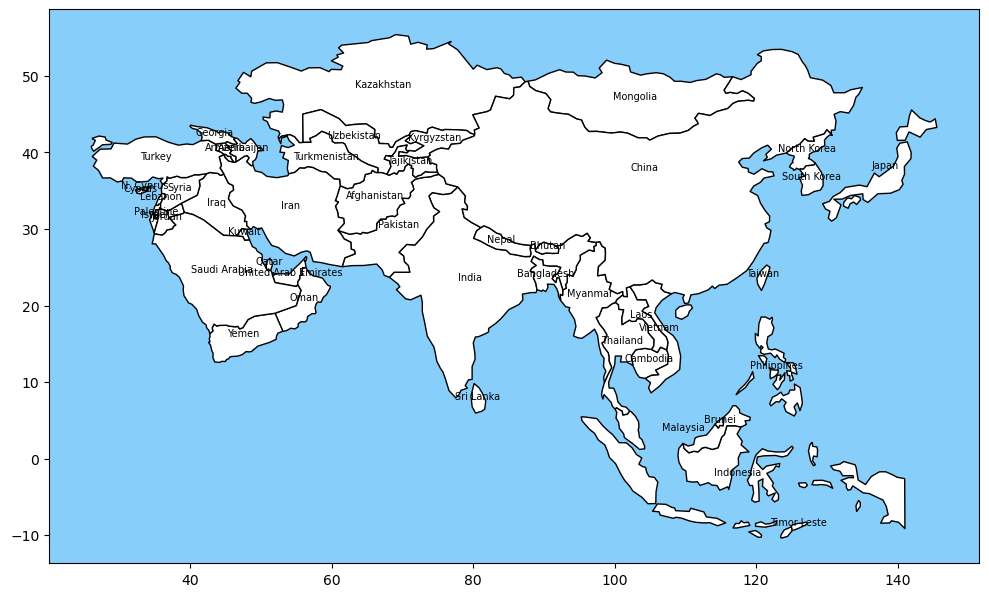

In [8]:
# Filter for Asia
asia = world[world.continent == 'Asia']

# Project to a suitable CRS for calculating centroids
asia_projected = asia.to_crs(epsg=3395)

# Create a GeoDataFrame for centroids in the projected CRS
centroids_projected = asia_projected.copy()
centroids_projected.geometry = centroids_projected['geometry'].centroid

# Project centroids back to geographic CRS for plotting
centroids = centroids_projected.to_crs(asia.crs)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot Asia
asia.plot(ax=ax, color='white', edgecolor='black')

# Set the ocean color
ax.set_facecolor('lightskyblue')

# Add country names
for idx, row in centroids.iterrows():
    plt.text(x=row.geometry.x, y=row.geometry.y, s=row['name'], 
             horizontalalignment='center', fontsize=7)

plt.show()

### We can also try to find neighbouring countries of an country

<Axes: >

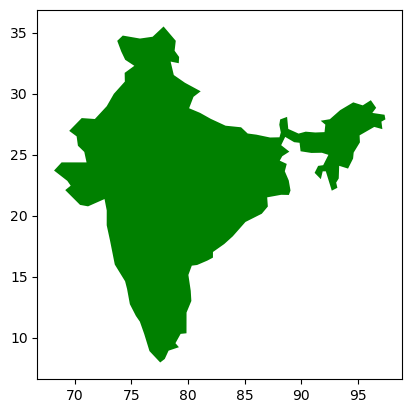

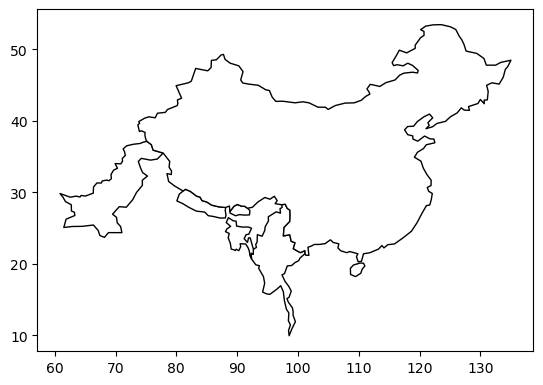

In [9]:
# Highlighting India and its neighboring countries
india = world[world['name'] == 'India']
neighbors = world[world.touches(india.geometry.squeeze())]

# Plot India and neighbors in different color
india.plot(color='green')
neighbors.plot(color='white', edgecolor='black')

In [10]:
neighbors.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
93,54045420.0,Asia,Myanmar,MMR,76085,"POLYGON ((100.11599 20.41785, 99.54331 20.1866..."
99,163046161.0,Asia,Bangladesh,BGD,302571,"POLYGON ((92.67272 22.04124, 92.65226 21.32405..."
100,763092.0,Asia,Bhutan,BTN,2530,"POLYGON ((91.69666 27.77174, 92.10371 27.45261..."
101,28608710.0,Asia,Nepal,NPL,30641,"POLYGON ((88.12044 27.87654, 88.04313 27.44582..."
102,216565318.0,Asia,Pakistan,PAK,278221,"POLYGON ((77.83745 35.49401, 76.87172 34.65354..."


In [11]:
us_map = world[world.name == "United States of America"]

states_df = pd.read_csv('us-state-capitals.csv')
# Rename columns in the second dataset
states_df = states_df.rename(columns={'name': 'state', 'description': 'state capitol'}
                             )
# Convert the DataFrames to GeoDataFrames
states_gdf = gpd.GeoDataFrame(states_df, geometry=gpd.points_from_xy(states_df.longitude, states_df.latitude))


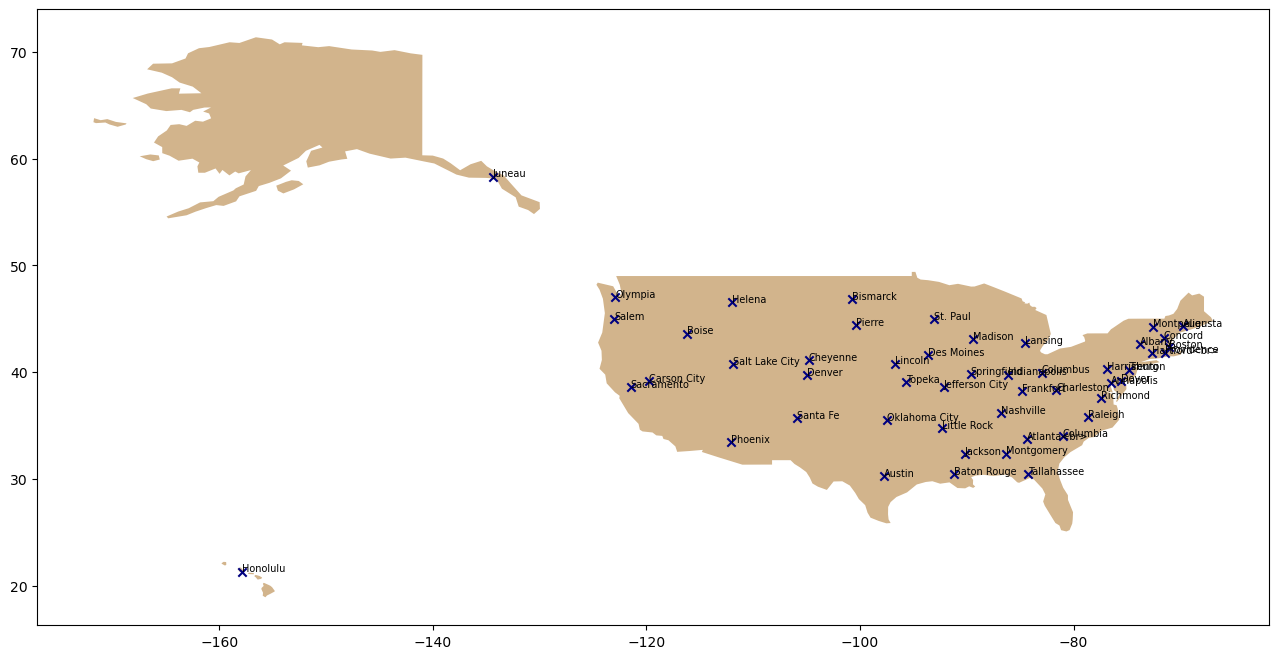

In [12]:
# Plotting
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the map of the United States
us_map.plot(ax=ax, color='tan')

# Overlay the state capitals
states_gdf.plot(ax=ax, color='navy', marker='x')

# Optionally, add labels for the capitals
for x, y, label in zip(states_gdf.geometry.x, states_gdf.geometry.y, states_gdf['state capitol']):
    ax.text(x, y, label, fontsize=7, color='black')

plt.show()

## Showing the boundry crossing using LineString and Point from shapely:

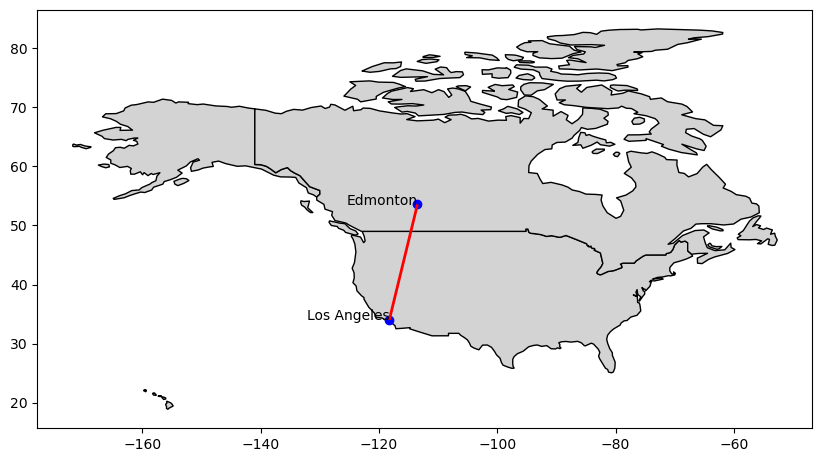

In [13]:
# Extract USA and Canada
usa = world[world.name == "United States of America"]
canada = world[world.name == "Canada"]

# Coordinates for Los Angeles and Edmonton
la_coords = (-118.2437, 34.0522)  # Los Angeles coordinates
edmonton_coords = (-113.4938, 53.5461)  # Edmonton coordinates

# Create Points for Los Angeles and Edmonton
la_point = Point(la_coords)
edmonton_point = Point(edmonton_coords)

# Create a LineString from Edmonton to Los Angeles
path = LineString([edmonton_coords, la_coords])

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot USA and Canada
usa.plot(ax=ax, color='lightgray', edgecolor='black')
canada.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot the cities
gpd.GeoSeries([la_point, edmonton_point]).plot(ax=ax, color='blue', marker='o')

# Plot the path with a distinct color and thicker line
gpd.GeoSeries([path]).plot(ax=ax, color='red', linewidth=2)

# Set labels for Los Angeles and Edmonton
ax.text(la_coords[0], la_coords[1], 'Los Angeles', horizontalalignment='right')
ax.text(edmonton_coords[0], edmonton_coords[1], 'Edmonton', horizontalalignment='right')

# Show the plot
plt.show()

### Lets us try to plot the world map based on the GDP.

In [14]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


<Axes: >

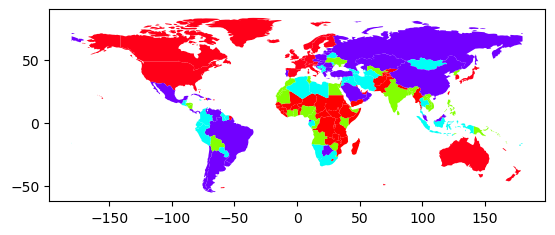

In [15]:
world['gdp_per_cap'] = world1.gdp_md_est / world1.pop_est

# color maps scaled can also be manipulated with the scheme
world.plot(column='gdp_per_cap', cmap='hsv', scheme='quantiles')

,community,NID,POP2010,POP2000,POPCH,POPPERCH,popplus,popneg,geometry
0,DOUGLAS,35,18238,26470,-8232,-31.099358,0,1,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,OAKLAND,36,5918,6110,-192,-3.142390,0,1,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,FULLER PARK,37,2876,3420,-544,-15.906433,0,1,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ..."
3,GRAND BOULEVARD,38,21929,28006,-6077,-21.698922,0,1,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
4,KENWOOD,39,17841,18363,-522,-2.842673,0,1,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."


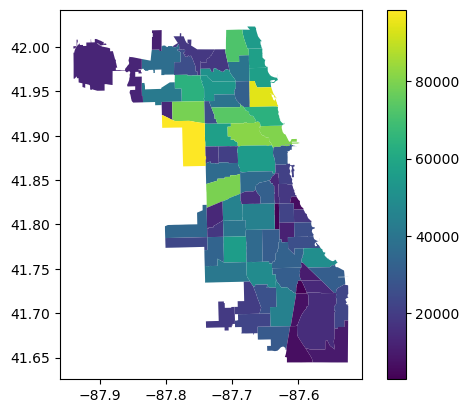

In [16]:
import geodatasets

chicago = gpd.read_file(geodatasets.get_path("geoda.chicago_commpop"))

chicago.plot(column="POP2010", legend=True)
chicago.head()

In [17]:
# Chicago healthIndicators
healthIndicators = gpd.read_file(geodatasets.get_path('geoda.healthIndicators'))

healthIndicators.head()

,area_num,shape_area,shape_len,comm_area,BirthRate,Gener_Rate,LowBi_ight,Prena_ster,Prete_rths,TeenB_Rate,...,Gonor_ales,Gono_les_1,Tuber_osis,Below_evel,Crowd_sing,Dependency,NoHig_loma,PerCa_come,Unemp_ment,geometry
0,35,4.600462e+07,31027.054510,DOUGLAS,10.3,42,11,76,10.2,34.2,...,1063.3,727.4,4.2,26.1,1.6,31.0,16.9,23098,16.7,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
1,36,1.691396e+07,19565.506153,OAKLAND,17.5,63,13,75,11.5,54.5,...,1655.4,1629.3,6.7,38.1,3.5,40.5,17.6,19312,26.6,"POLYGON ((-87.59215 41.81693, -87.59231 41.816..."
2,37,1.991670e+07,25339.089750,FULLER PARK,11.9,60,17,71,14.3,69.2,...,1061.9,1556.4,0.0,55.5,4.5,38.2,33.7,9016,40.0,"POLYGON ((-87.62880 41.80189, -87.62879 41.801..."
3,38,4.849250e+07,28196.837157,GRAND BOULEVARD,14.3,58,12,74,13.7,54.8,...,1454.6,1680.0,13.2,28.3,2.7,41.7,19.4,22056,20.6,"POLYGON ((-87.60671 41.81681, -87.60670 41.816..."
4,39,2.907174e+07,23325.167906,KENWOOD,12.2,51,11,77,11.9,25.7,...,610.2,549.1,0.0,23.1,2.3,34.2,10.8,37519,11.0,"POLYGON ((-87.59215 41.81693, -87.59215 41.816..."


In [18]:
# Interactive mapping

healthIndicators.explore()

## Let’s look only at the boundary of OHARE

In [19]:
ohare_area = healthIndicators[healthIndicators['comm_area'] == 'OHARE']

# Extract the boundary
ohare_boundary = ohare_area.boundary
ohare_boundary.explore()

## Spatial Join of chicago dataset with chicago grocaries dataset.

In [20]:
groceries = gpd.read_file(geodatasets.get_path("geoda.groceries"))

In [21]:
# chicago columns info
chicago.head(3)

,community,NID,POP2010,POP2000,POPCH,POPPERCH,popplus,popneg,geometry
0,DOUGLAS,35,18238,26470,-8232,-31.099358,0,1,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,OAKLAND,36,5918,6110,-192,-3.142390,0,1,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,FULLER PARK,37,2876,3420,-544,-15.906433,0,1,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ..."


In [22]:
# groceries columns info
groceries.head(3)

,OBJECTID,Ycoord,Xcoord,Status,Address,Chain,Category,geometry
0,16,41.973266,-87.657073,OPEN,"1051 W ARGYLE ST, CHICAGO, IL. 60640",VIET HOA PLAZA,NaN,MULTIPOINT (1168268.672 1933554.350)
1,18,41.696367,-87.681315,OPEN,"10800 S WESTERN AVE, CHICAGO, IL. 60643-3226",COUNTY FAIR FOODS,NaN,MULTIPOINT (1162302.618 1832900.224)
2,22,41.868634,-87.638638,OPEN,"1101 S CANAL ST, CHICAGO, IL. 60607-4932",WHOLE FOODS MARKET,NaN,MULTIPOINT (1173317.042 1895425.426)


## Now lets do spatial join of the both data as both the datasets are based on chicago

In [23]:
# spatial join on chicago[['geometry', 'community']] with groceries
chicago = chicago[['geometry', 'community']].to_crs(groceries.crs)

chicago.head()

,geometry,community
0,"MULTIPOLYGON (((1181573.250 1886828.039, 11815...",DOUGLAS
1,"MULTIPOLYGON (((1186289.356 1876750.733, 11862...",OAKLAND
2,"MULTIPOLYGON (((1176344.998 1871187.546, 11763...",FULLER PARK
3,"MULTIPOLYGON (((1182322.043 1876674.730, 11823...",GRAND BOULEVARD
4,"MULTIPOLYGON (((1186289.356 1876750.733, 11862...",KENWOOD


References
1. https://geopandas.org/en/stable/docs.html
2. https://geopandas.org/en/stable/gallery/spatial_joins.html
3. Most of the datasets in GeoDatasets is from University of Chicago. Sorry for confusion during the video explaination.